In [6]:
from datasets import load_from_disk

SEED = 123
FOLDER = "../data/processed/legal-qa-v1"

In [7]:
dataset = load_from_disk(FOLDER)

In [12]:
#check the dataset
print(dataset)
print(dataset['train'][0])
print(dataset['validation'][0])
print(dataset['test'][0])

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 2992
    })
    validation: Dataset({
        features: ['question', 'answer'],
        num_rows: 375
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 375
    })
})
{'question': "The Skullgirls team has taken a digital product that many people purchased and altered it in very significant ways.. The Skullgirls team has taken a digital product that many people purchased and altered it in very significant ways. They've cut out entire pages from the art book, removed and re-announced voice lines, and drawn over concept art to make it less offensive. The current Skullgirls team, while many of them have ties to the very beginning of the game, is not the same team it was at the beginning. They're missing some of the most important contributors to the Skullgirls brand. They're also literally a completely different company than the original Lab Zero, who is now ce

In [62]:
dataset["answer"]

Column(["A:In Kentucky, your situation raises questions about patient rights and medical records access. If you were discharged from a pain management office and subsequently lost access to your patient portal, it's important to understand your rights regarding medical records. Under the Health Insurance Portability and Accountability Act (HIPAA), you have the right to access your own medical records. A healthcare provider cannot deny you access to your records, even if you were discharged from their practice. The issue with the patient portal could be a technical glitch or a deliberate action, but either way, it needs to be addressed. You should contact the pain management office directly to inquire about the issue with the patient portal. They are obligated to provide you with a way to access your medical records, which may include providing paper copies or access through a different electronic means. If the office is unresponsive or refuses to provide access to your records, conside

In [63]:
def transform(example):
    # ejemplo: poner preguntas en mayúsculas y respuestas en minúsculas
    new_question = example["question"].replace("Q:", "").strip()
    new_answer = example["answer"].replace("A:", "").strip()

    return {
        "question": new_question,
        "answer": new_answer
    }

In [64]:
transformed_dataset = dataset.map(transform)

In [65]:
print(transformed_dataset["question"][0])
print(transformed_dataset["answer"][0])

I was wondering if a pain management office is acting illegally/did an illegal action.. I was discharged as a patient from a pain management office after them telling me that a previous pain management specialist I saw administered a steroid shot wrong and I told them in the portal that I spoke to lawyers for advice but no lawsuit/case was created. It was maybe 1-2 months after I was discharged that I no longer have access to my patient portal with them. Every time I try to login I enter my credentials, wait a few seconds, and then I get re-directed back to the original screen where I have various options to login. I know I can speak to the office directly and ask them about what specifically is going on, talk to other lawyers if this is a violation of my rights, etc. but I was just wondering if anyone on this site would know if this action is in fact illegal.
In Kentucky, your situation raises questions about patient rights and medical records access. If you were discharged from a pai

In [66]:
# split the dataset into train and validation
train_test = transformed_dataset.train_test_split(test_size=0.2, seed=SEED)
print(train_test)
train_val = train_test["test"].train_test_split(test_size=0.5, seed=SEED)
transformed_dataset = {
    "train": train_test["train"],
    "val": train_val["test"],
    "test": train_val["train"]
}

DatasetDict({
    train: Dataset({
        features: ['question', 'answer'],
        num_rows: 2993
    })
    test: Dataset({
        features: ['question', 'answer'],
        num_rows: 749
    })
})


In [67]:
transformed_dataset

{'train': Dataset({
     features: ['question', 'answer'],
     num_rows: 2993
 }),
 'val': Dataset({
     features: ['question', 'answer'],
     num_rows: 375
 }),
 'test': Dataset({
     features: ['question', 'answer'],
     num_rows: 374
 })}

## Embeddings

In [1]:
from typing import List
from langchain_core.embeddings import Embeddings
from sentence_transformers import SentenceTransformer


class SentenceTransformerEmbeddings(Embeddings):

    def __init__(self, model: str, device: str = 'cuda'):
        self.model = SentenceTransformer(model, device=device)

    def embed_documents(self, texts: List[str]) -> List[List[float]]:
        """Embed search docs."""
        return self.model.encode(texts).tolist()

    def embed_query(self, text: str) -> List[float]:
        """Embed query text."""
        return self.model.encode_query(text).tolist()

/home/miguel/miniconda3/envs/RAG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from langchain_community.vectorstores import FAISS

model = SentenceTransformerEmbeddings(model="all-mpnet-base-v2")

loaded_vectorstore=FAISS.load_local(
    "../data/db/ragbench-delucionqa/ragbench-delucionqa_embeddings_all-mpnet-base-v2",
    model,
    allow_dangerous_deserialization=True
)

print(f"Loaded vector store contains {loaded_vectorstore.index.ntotal} vectors")

Loaded vector store contains 930 vectors


In [7]:
# get all embeddings in numpy array
import numpy as np
all_embeddings = np.array([emb for emb in loaded_vectorstore.index.reconstruct_n(0, loaded_vectorstore.index.ntotal)])
print(f"All embeddings shape: {all_embeddings.shape}")

All embeddings shape: (930, 768)


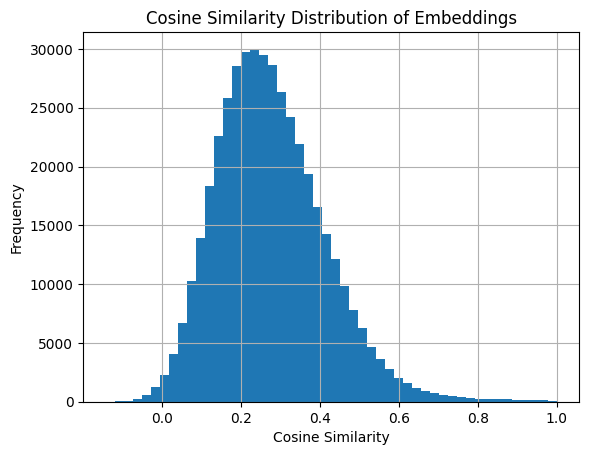

In [8]:
# plot histogram of the embeddings cosine similarity distribution

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarities = cosine_similarity(all_embeddings)
# get the upper triangle of the cosine similarities matrix, without the diagonal
upper_triangle_indices = np.triu_indices_from(cosine_similarities, k=1)
upper_triangle_values = cosine_similarities[upper_triangle_indices]

plt.hist(upper_triangle_values, bins=50)
plt.grid()
plt.title("Cosine Similarity Distribution of Embeddings")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [5]:
# print the mean and standard deviation of the cosine similarities
mean_cosine_similarity = np.mean(upper_triangle_values)
std_cosine_similarity = np.std(upper_triangle_values)
# print the results rounded to 4 decimal places
print(f"Mean Cosine Similarity: {mean_cosine_similarity:.4f}")
print(f"Standard Deviation of Cosine Similarity: {std_cosine_similarity:.4f}")

Mean Cosine Similarity: 0.4139
Standard Deviation of Cosine Similarity: 0.1128


In [2]:
from datasets import load_dataset

# load train/validation/test splits of individual subset
ragbench_hotpotqa = load_dataset("rungalileo/ragbench", "hotpotqa")
print(ragbench_hotpotqa)

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'documents', 'response', 'generation_model_name', 'annotating_model_name', 'dataset_name', 'documents_sentences', 'response_sentences', 'sentence_support_information', 'unsupported_response_sentence_keys', 'adherence_score', 'overall_supported_explanation', 'relevance_explanation', 'all_relevant_sentence_keys', 'all_utilized_sentence_keys', 'trulens_groundedness', 'trulens_context_relevance', 'ragas_faithfulness', 'ragas_context_relevance', 'gpt3_adherence', 'gpt3_context_relevance', 'gpt35_utilization', 'relevance_score', 'utilization_score', 'completeness_score'],
        num_rows: 1883
    })
    test: Dataset({
        features: ['id', 'question', 'documents', 'response', 'generation_model_name', 'annotating_model_name', 'dataset_name', 'documents_sentences', 'response_sentences', 'sentence_support_information', 'unsupported_response_sentence_keys', 'adherence_score', 'overall_supported_explanation', 'relevance

In [27]:
ragbench = {}
for dataset in ['covidqa', 'cuad', 'delucionqa', 'emanual', 'expertqa', 'finqa', 'hagrid', 'hotpotqa', 'msmarco', 'pubmedqa', 'tatqa', 'techqa']:
  ragbench[dataset] = load_dataset("rungalileo/ragbench", dataset)

In [28]:
ragbench

{'covidqa': DatasetDict({
     train: Dataset({
         features: ['id', 'question', 'documents', 'response', 'generation_model_name', 'annotating_model_name', 'dataset_name', 'documents_sentences', 'response_sentences', 'sentence_support_information', 'unsupported_response_sentence_keys', 'adherence_score', 'overall_supported_explanation', 'relevance_explanation', 'all_relevant_sentence_keys', 'all_utilized_sentence_keys', 'trulens_groundedness', 'trulens_context_relevance', 'ragas_faithfulness', 'ragas_context_relevance', 'gpt3_adherence', 'gpt3_context_relevance', 'gpt35_utilization', 'relevance_score', 'utilization_score', 'completeness_score'],
         num_rows: 1252
     })
     test: Dataset({
         features: ['id', 'question', 'documents', 'response', 'generation_model_name', 'annotating_model_name', 'dataset_name', 'documents_sentences', 'response_sentences', 'sentence_support_information', 'unsupported_response_sentence_keys', 'adherence_score', 'overall_supported_explan

In [29]:
ragbench["covidqa"]["train"][0]

{'id': '358',
 'question': 'What role does T-cell count play in severe human adenovirus type 55 (HAdV-55) infection?',
 'documents': ['Title: Emergent severe acute respiratory distress syndrome caused by adenovirus type 55 in immunocompetent adults in 2013: a prospective observational study\nPassage: Recent studies have shown that the immune system plays a crucial role in the clearance of HAdV viremia and survival of the host . Chen et al. reported that, in the acute phase of HAdV-55 infection, patients with severe disease may have high levels of dendritic cells and Th17 cells . In our study, the only patient who recovered from severe infection had higher T-cell counts. Three of the five patients had relatively low T-cell counts when admitted. Our results suggest that these three patients may have been relatively immunocompromised and that a lower T-cell count may be a risk',
  'Title: Emergent severe acute respiratory distress syndrome caused by adenovirus type 55 in immunocompetent a

In [30]:
## quiero solo estas columnas
columns_to_keep = ["id", "question", "documents", "response"]
for subset in ragbench:
    ragbench[subset] = ragbench[subset].remove_columns([col for col in ragbench[subset]['train'].column_names if col not in columns_to_keep])

In [31]:
document = []
for split in ragbench["covidqa"]:
    for docs in ragbench["covidqa"][split]["documents"]:
        for doc in docs:
            document.append(doc)

In [32]:
len(document)

7060

In [34]:
# check unique documents in alphabetical order
len(set(document))
unique_documents = list(set(document))
unique_documents.sort()

In [35]:
# create new column with the idx of the document in the list of unique documents, the idx should be a list of integers and the name of the column should be "document_ids"
unique_documents = list(set(document))
unique_documents.sort()
document_idx_map = {doc: idx for idx, doc in enumerate(unique_documents)}
for split in ragbench["covidqa"]:
    ragbench["covidqa"][split] = ragbench["covidqa"][split].add_column(
        "document_ids",
        [[document_idx_map[doc] for doc in docs] for docs in ragbench["covidqa"][split]["documents"]]
    )
ragbench["covidqa"]["train"][0]

{'id': '358',
 'question': 'What role does T-cell count play in severe human adenovirus type 55 (HAdV-55) infection?',
 'documents': ['Title: Emergent severe acute respiratory distress syndrome caused by adenovirus type 55 in immunocompetent adults in 2013: a prospective observational study\nPassage: Recent studies have shown that the immune system plays a crucial role in the clearance of HAdV viremia and survival of the host . Chen et al. reported that, in the acute phase of HAdV-55 infection, patients with severe disease may have high levels of dendritic cells and Th17 cells . In our study, the only patient who recovered from severe infection had higher T-cell counts. Three of the five patients had relatively low T-cell counts when admitted. Our results suggest that these three patients may have been relatively immunocompromised and that a lower T-cell count may be a risk',
  'Title: Emergent severe acute respiratory distress syndrome caused by adenovirus type 55 in immunocompetent a

In [ ]:
# save to disk the list of unique documents in jsonl format
import os
import json

with open("../data/processed/ragbench/covidqa_unique_documents.jsonl", "w") as f:
    for doc in unique_documents:
        f.write(json.dumps({"document": doc}) + "\n")

# Parliamentary data

In [24]:
from datasets import load_from_disk
FOLDER_AUTORE = "../data/raw/ORDERS_PARLIAMENT" # Entrenamiento autoregresivo

In [25]:
dataset_aut = load_from_disk(FOLDER_AUTORE) 

In [26]:
dataset_aut

DatasetDict({
    train: Dataset({
        features: ['text', 'PK'],
        num_rows: 10045
    })
    validation: Dataset({
        features: ['text', 'PK'],
        num_rows: 893
    })
    test: Dataset({
        features: ['text', 'PK'],
        num_rows: 224
    })
})

In [10]:
print(dataset['train'][0])

{'text': 'Esta sesión del parlamento se realizó el 2024-05-07. 11L/PO/P-0750 PREGUNTA DEL SEÑOR DIPUTADO DON NICASIO JESÚS GALVÁN SASIA, DEL GRUPO PARLAMENTARIO VOX, SOBRE MEDIDAS QUE SE VAN A LLEVAR A CABO PARA DEMOCRATIZAR Y REDISTRIBUIR LA RIQUEZA DEL SECTOR TURÍSTICO, DIRIGIDA A LA PRESIDENCIA DEL GOBIERNO La señora PRESIDENTA: Siguiente pregunta, del señor diputado don Nicasio Galván Sasia, del Grupo Parlamentario VOX, sobre medidas que se van a llevar a cabo para democratizar y redistribuir la riqueza del sector turístico, dirigida al señor presidente del Gobierno. Cuando quiera. El señor GALVÁN SASIA (desde su escaño): Buenos días, señor Clavijo, buenos días. Escuchándole en la rueda de prensa posterior a la Conferencia de Presidentes nos han surgido varias preguntas, y nos consta que no solo a nosotros. Se le oía escuchar hablar de la democratización y la redistribución de la riqueza del sector turístico y culpabilizó al turismo -sí, a esas 500 000 personas que han venido a viv

In [23]:
import json
FOLDER_QA = "../data/raw/QA_PARLIAMENT_TRAIN"

dataset_qa = load_from_disk(FOLDER_QA)
print(dataset_qa)
print(dataset_qa["train"])
print(json.dumps(dataset_qa['train'][3], indent=2))

DatasetDict({
    train: Dataset({
        features: ['PK', 'question', 'answer', 'cost', 'context', 'type', 'retrieved_pks', 'oracle_context', 'formatted_context'],
        num_rows: 614
    })
    validation: Dataset({
        features: ['PK', 'question', 'answer', 'cost', 'context', 'type', 'retrieved_pks', 'oracle_context', 'formatted_context'],
        num_rows: 161
    })
})
Dataset({
    features: ['PK', 'question', 'answer', 'cost', 'context', 'type', 'retrieved_pks', 'oracle_context', 'formatted_context'],
    num_rows: 614
})
{
  "PK": "6521_1",
  "question": "\u00bfQu\u00e9 argumentos expuso el grupo parlamentario que se opuso a la propuesta de modificaci\u00f3n del orden del d\u00eda en la sesi\u00f3n del 26 de septiembre de 2023, que implicaba la convalidaci\u00f3n del decreto relativo al impuesto de sucesiones y donaciones?",
  "answer": "El fragmento del Diario de Sesiones no proporciona argumentos espec\u00edficos de ning\u00fan grupo parlamentario que se oponga a la pr

In [21]:
import json
FOLDER_QA = "../data/raw/QA_PARLIAMENT_TEST"

dataset_qa = load_from_disk(FOLDER_QA)
print(dataset_qa["test"])
print(json.dumps(dataset_qa['test'][3], indent=2))

Dataset({
    features: ['question', 'PK', 'answer', 'type', 'retrieved_pks', 'oracle_context', 'injected_oracle', 'formatted_context'],
    num_rows: 205
})
{
  "question": "\u00bfEn qu\u00e9 contexto se le concedi\u00f3 el uso de la palabra al diputado Jos\u00e9 Miguel Ruano Le\u00f3n durante la sesi\u00f3n del Parlamento de Canarias del 10 de octubre de 2012, tras haber hecho alusiones personales en su intervenci\u00f3n?",
  "PK": "5861_8",
  "answer": "Por alusiones, el se\u00f1or Jos\u00e9 Miguel Ruano Le\u00f3n solicita el uso de la palabra para responder a comentarios realizados por el portavoz del Grupo Popular.",
  "type": "exceptional_turn",
  "retrieved_pks": [
    "5825_5",
    "6057_5",
    "5478_14",
    "5835_3",
    "6073_2",
    "5860_19",
    "6156_9"
  ],
  "oracle_context": false,
  "injected_oracle": false,
  "formatted_context": "[Documento 1]\nEsta sesi\u00f3n del parlamento se realiz\u00f3 el 2012-03-06. \u00b7 8L/PO/P-0247 Pregunta del se\u00f1or diputado don J